In [114]:
# Imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from time import time
import os
import random
import numpy as np
from PIL import Image

# Set seed for reproducibility
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Set up warnings
import warnings
warnings.filterwarnings(
    action='ignore',
    category=DeprecationWarning,
    module=r'.*'
)
#warnings.filterwarnings(
#    action='default',
#    module=r'torch.ao.quantization'
#)
warnings.filterwarnings('ignore')
#KNOEDEL: Knowledgible Excellent Detector of Edible Loveliness 
class KnoedelNet(nn.Module):
    def __init__(self):
        super(KnoedelNet, self).__init__()
        self.net = nn.Sequential(
            # input: 3x64x64
            nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            # input: 8x32x32
            nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # input: 16x16x16
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # input: 32x8x8
            nn.Flatten(),
            nn.Linear(8**2*32, 2),
        )
    
    def forward(self, x):
        return self.net(x)

class KnoedelSet(Dataset):
    def __init__(self, root, train:bool=False, transform=None):
        super(KnoedelSet, self).__init__()
        self.root = root
        self.train = train
        self.transform = transform
        self.phase = "train" if train else "test"
        # load images and labels
        self.data = np.loadtxt(os.path.join(self.root, self.phase, "labels.csv"), delimiter=",", skiprows=1, dtype='str')
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, label = self.data[idx, 0], int(self.data[idx, 1])
        img = Image.open(os.path.join(self.root, self.phase, 'images', img)).convert("RGB")
        img = img.resize((64, 64))
        if self.transform:
            img = self.transform(img)
        return img, label

results = {}

def train_loop(train_dataloader, model, loss_fn, optimizer, device="cpu"):
    model.train()
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_loop(test_dataloader, model, loss_fn, device="cpu"):
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    test_loss, correct = 0, 0
    model.eval()

    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    return correct, test_loss

def fit(epochs, loss_fn, optimizer, model, train_dataloader, test_dataloader, device="cpu"):
    print(f"Training for {epochs} epochs...")
    model = model.to(device)
    accs, losses = [], []
    t1 = time()
    for t in tqdm(range(epochs)):
        train_loop(train_dataloader, model, loss_fn, optimizer, device)
        acc, loss = test_loop(test_dataloader, model, loss_fn, device)
        accs.append(acc)
        losses.append(loss)
    t2 = time()
    return accs, losses, t2-t1

def test(loss_fn, model, test_dataloader, device="cpu"):
    model = model.to(device)
    t1 = time()
    acc, loss = test_loop(test_dataloader, model, loss_fn, device)
    t2 = time()
    return acc, loss, t2-t1

def plot_results(results, name, title=None):
    # plot accs and losses, next to each other
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    if title:
        fig.suptitle(title)
    ax1.plot(results["test_accuracy"][name])
    ax1.title.set_text('Test Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')

    ax2.plot(results["test_loss"][name])
    ax2.title.set_text('Test Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Cross Entropy Loss')
    plt.show()

def create_table(results: dict[str,dict[str,float]], title=None):
    metric_names = list(results.keys())

    # Create a new figure with a specific size
    fig, ax = plt.subplots(figsize=(5, 3))  # set the size that fits

    # Hide the axes
    ax.axis('off')

    # Create the table. The first column will be the metrics, and then the subsequent columns will be the training runs
    table_data = []
    header = ["Metric"] + list(results[metric_names[0]].keys())
    table_data.append(header)
    # for metric, data in zip(metrics, training_data):
    for metric in metric_names:

        row = list(results[metric].values())
        # if isinstance(row[0], list):
        row = [ i[-1] if isinstance(i, list) else i for i in row] 

        if metric == "train_time":
            row = [f"{i:.2f}s" for i in row]
        elif metric == "test_accuracy":
            row = [f"{i*100:.2f}%" for i in row]
        elif metric == "test_loss":
            row = [f"{i:.2f}" for i in row]
        elif metric == "model_size":
            row = [f"{i/1e3:.2f}KB" for i in row]
        elif metric == "test_time":
            row = [f"{i:.2f}s" for i in row]
        elif metric == "size_fraction":
            row = [f"{i*100:.2f}%" for i in row]

        table_data.append([metric] + row)

    tab = ax.table(cellText=table_data, cellLoc='right', loc='center', colWidths=[0.1] + [0.1] * len(results["train_time"]))
    tab.scale(3, 2)

    if title:
        plt.title(title)
        #plt.tight_layout()
    plt.show()
    #plt.tight_layout()
    fig.savefig("table.png")

    
# def model_size(model):
#     # in MB
#     return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6

def model_size_bytes(model):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    # print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

def update_results_dict(results, name, acc, loss, train_time, test_time, model_size, size_fraction):
    # add new key if not already in dict
    if "test_accuracy" not in results:
        results["test_accuracy"] = {}
        results["test_loss"] = {}
        results["train_time"] = {}
        results["test_time"] = {}
        results["model_size"] = {}
        results["size_fraction"] = {}
        
    results["test_accuracy"].update({name: acc})
    results["test_loss"].update({name: loss})
    results["train_time"].update({name: train_time})
    results["test_time"].update({name: test_time})
    results["model_size"].update({name: model_size})
    results["size_fraction"].update({name: size_fraction})

# Quantizing KNOEDEL: An Knowledgible Efficient Detector of Edible Loveliness
Ferienakademie 2023<br>

Course 3<br>

## Outline
- Eager Mode Quantization
    - Post training dynamic quntization (PTQ dynamic)
    - Post training static quantization (PTQ static)
    - Quantization Aware Training (QAT)

Components of a typical training pipeline:
- Dataset, Dataloader
- Network: `nn.Module`, modular compositions system based on python class inhertiance
- Loss function
- Optimizer: Implements weight update algorithm

### Dataset
- Pre-defined datasets available `torchvision.datasets`
- Define your own by extending `nn.utils.data.Dataset`


Let's use KnoedelSet:

In [115]:
training_data = KnoedelSet(root='data', train=True, transform=transforms.ToTensor())
test_data = KnoedelSet(root='data', train=False, transform=transforms.ToTensor())

### KnoedelSet: Knödel Classification
- Images of Knödels and other objects (tennis, table tennis, )
- $128\times 128$ color images ($64\times 64$ after preprocessing)
- Ground truth labels (Knödel or not Knödel)

Datashape: torch.Size([3, 64, 64])
Number training samples: 190


Text(0.5, 1.0, 'Ground truth: 1')

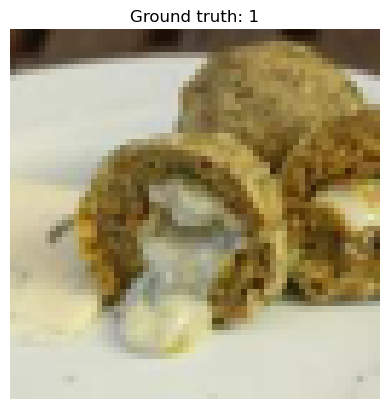

In [116]:
sample_id = 4
# TODO 9 images
image, label = training_data[sample_id]
print(f"Datashape: {image.shape}")
print(f"Number training samples: {len(training_data)}")
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.title(f"Ground truth: {label}")

### Dataloader
- Loads data from disk and executes pre-processing steps
- Creates batches
- Shuffels data
- $\rightarrow$ Can be parallelized


In [117]:
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1)

### Neural Network Model Definition
<!-- To define the network let's look at the dataset dimensions: -->
Let's use a CNN with $(B, 3, 64, 64)$ as input:
- 3x (3x3 Convolution + Batchnorm + ReLU)
- Flatten dimensionality
- Fully Conntected (Dense)
![](nn_cropped.svg)

![](nn_cropped.svg)


### Model Instantiation, Loss Function and Optimizer

In [118]:
model_fp32 = KnoedelNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_fp32.parameters(), lr=1e-3, weight_decay=1e-5, momentum=0.9)

### Training Loop

In [119]:
def train_loop(train_dataloader, model, loss_fn, optimizer, device="cpu"):
    # model to training mode
    model.train()
    for X, y in train_dataloader:
        # move data to used device e.g. GPU
        X, y = X.to(device), y.to(device)
        
        # compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation and weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

### Let's train for 5 epochs...

Training for 20 epochs...


100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


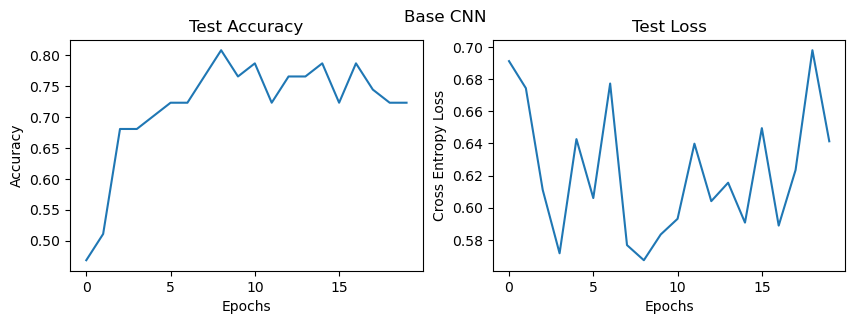

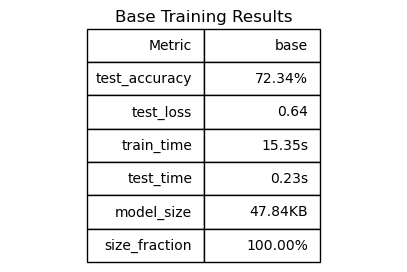

In [120]:
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 20
accs, losses, train_time = fit(epochs, loss_fn, optimizer, model_fp32, train_dataloader, test_dataloader, device)
_, _, test_time = test(loss_fn, model_fp32, test_dataloader, device)
update_results_dict(results, "base", accs, losses, train_time, test_time, model_size_bytes(model_fp32), 1)
plot_results(results, "base", "Base CNN")
create_table(results, title="Base Training Results")

## Quantization in PyTorch
Idea: Convert `fp32` to `int8`
  - Smaller model size
  - Decreased inference time
  - $\rightarrow$ runnable on CPU e.g. edge devices
  - $\rightarrow$ runnable on smaller GPUs e.g. LLMs (experimental)

### Quantization APIs

- **Eager Mode Quantization** (beta):
    - Quantize PyTorch modules (no functions)
    - Manually specify quantization moment and layer fusion (PTQ static and QAT)
    - $\rightarrow$ Adaptation of network model required

- **FX Graph Mode Quantization** (experimental):
    - Automated quantization framework, improves eager mode
    - Needs symbolically traceability of the module
    - $\rightarrow$ adaptation of the network might be required

## Eager Mode Quantization
Methods:
- Post Training Quantization (PTQ)
- Quantization Aware Training (QAT)
<!--
Supports:
- symmetric and asymmetric quantization
- per-tensor and per-channel quantization
-->

General quantization implementation flow:
1. Prepare model
2. Callibrate or re-train
3. Convert to `int8`

### Post Training Dynamic Quantization (PTQ dynamic)

- Weights are quantized ahead of time
- Activations are dynamically quantized (dq) at runtime
- Fast `int8` operations

```
previous_layer_fp32 -- linear_int8_w_fp32_inp -- activation_fp32 -- next_layer_fp32
                     /
   linear_weight_int8
```

```
previous_layer_fp32 -- dq -- linear_int8 -- activation_fp32 -- next_layer_fp32
                             /
           linear_weight_int8
```

### Use Case
- Limited memory bandwidth, weight loading is a bottleneck
- Limited memory
<!-- Limited memory bandwidth during inference-->

$\rightarrow$ LSTMs and transfomers with small batchsize

### PyTorch API
1. ~~Prepare model~~
3. ~~Callibrate or re-train~~
3. Convert to `int8`

In [121]:
model_ptq_dyn_int8 = torch.quantization.quantize_dynamic(
    # model            layer types to quant.   data type to quant. to
    model_fp32.cpu(), {nn.Conv2d, nn.Linear}, dtype=torch.qint8
)

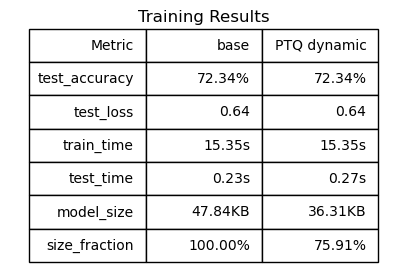

In [122]:
dyn_quant_acc, dyn_quant_loss, dyn_quant_test_time = test(loss_fn, model_ptq_dyn_int8, test_dataloader, device)
update_results_dict(results, "PTQ dynamic", dyn_quant_acc, dyn_quant_loss, train_time, dyn_quant_test_time, model_size_bytes(model_ptq_dyn_int8), model_size_bytes(model_ptq_dyn_int8)/model_size_bytes(model_fp32))
create_table(results, title="Training Results")

### Post Training Static Quantization (PTQ static)
- Quantize weights **and** activations ahead of time
<!-- - Layer + activation fusion: conv + batchnorm + relu-->
- `Observer` module
    - Measure activation statistics, to quantize according to data range
    - Supported: per-channel and per-tensor quant.
    - $\rightarrow$ Needs forward pass with representative dataset
   



- Layer fusion
    - Combine operations to obtain higher precision
    - Currently supported: [conv, relu], [conv, bn], [conv, bn, relu], [linear, relu]

```
previous_layer_int8 -- linear_with_activation_int8 -- next_layer_int8
                    /
  linear_weight_int8
```

### Use Case
Both memory bandwidth **and** compute savings are relevant

$\rightarrow$ CNNs on edge devices

### PyTorch API
Need to adjust model:

In [123]:
class AdjustedKnoedelNet(nn.Module):
    def __init__(self, model_fp32):
        super(AdjustedKnoedelNet, self).__init__()
        self.quant = torch.ao.quantization.QuantStub()
        self.model_fp32 = model_fp32
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        logits = self.model_fp32(x)
        logits = self.dequant(logits)
        return logits

### PyTorch API Continued
1. Prepare model
    - Platform specific confguration: x86 uses per channel quant.
    - Fuse layers: conv + batchnorm + relu
    - Attach observer

In [124]:
model_fp32_adjusted = AdjustedKnoedelNet(model_fp32)
model_fp32_adjusted.eval()
model_fp32_adjusted.qconfig = torch.ao.quantization.get_default_qconfig('x86')

In [125]:
model_fp32_fused = torch.ao.quantization.fuse_modules(
    model_fp32_adjusted,
    [['model_fp32.net.0', 'model_fp32.net.1', 'model_fp32.net.2'],
     ['model_fp32.net.3', 'model_fp32.net.4', 'model_fp32.net.5'],
     ['model_fp32.net.6', 'model_fp32.net.7', 'model_fp32.net.8']]
)

In [126]:
model_fp32_ptq_static = torch.ao.quantization.prepare(model_fp32_fused)

2. Callibrate by forwarding representative data

In [127]:
_, _, _ = test(loss_fn, model_fp32_ptq_static, train_dataloader, device)

3. Convert to `int8`

In [128]:
model_int8_ptq_static = torch.ao.quantization.convert(model_fp32_ptq_static)

### Results

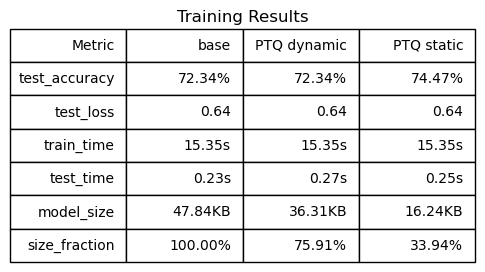

In [129]:
stat_quant_acc, stat_quant_loss, stat_quant_test_time = test(loss_fn, model_int8_ptq_static, test_dataloader, device)
update_results_dict(results, "PTQ static", stat_quant_acc, stat_quant_loss, train_time, stat_quant_test_time, model_size_bytes(model_int8_ptq_static), model_size_bytes(model_int8_ptq_static)/model_size_bytes(model_fp32))
create_table(results, title="Training Results")

### Quantization Aware Training (QAT)

- Add-on to static quantization
- Fine-tune on simulated quantization error
- $\rightarrow$ `FakeQuantize` module (fq)
    - Simulate quantization for tensor
    - Observe activation statistics (replaces observer)

**During Training:**
```
previous_layer_fp32 -- fq -- linear_fp32 -- activation_fp32 -- fq -- next_layer_fp32
                          /
  linear_weight_fp32 -- fq
```



**During Inference:**
```
previous_layer_int8 -- linear_with_activation_int8 -- next_layer_int8
                    /
  linear_weight_int8
```

### PyTorch API
<!--1. Fuse modules (already done before)
2. Configure quantization (default: uniform per channel min/max over data histogram)
3. Attach observers
4. Train model
5. Convert to int8
-->
<!--
1. Prepare model
    - Configure 
    - Fuse fully connected and activation layer
    - Attach observer
2. Callibrate by forwarding representative data
3. Convert to `int8`
-->
1. Prepare model
    - Layers already fused
    - Platform specific confguration 
    - Attach fake quantizers

In [130]:
model_fp32_fused.train()
model_fp32_fused.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')
model_fp32_qat = torch.ao.quantization.prepare_qat(model_fp32_fused)

2. Re-train model

Training for 20 epochs...


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


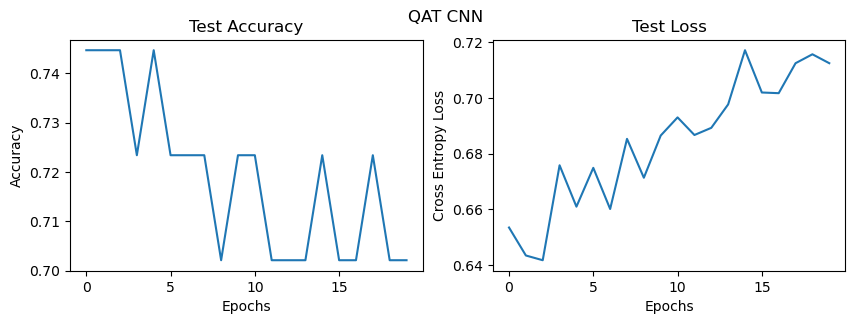

In [131]:
# new model -> new optimizer
optimizer = torch.optim.SGD(model_fp32_qat.parameters(), lr=1e-3, weight_decay=1e-5, momentum=0.9)
# re-train
accs, losses, train_time = fit(epochs, loss_fn, optimizer, model_fp32_qat, train_dataloader, test_dataloader, device)
model_fp32_qat.eval()
update_results_dict(results, "QAT", accs, losses, train_time, 0, 0, 0)
plot_results(results, "QAT", "QAT CNN")

3. Convert to `int8`

In [132]:
model_int8_qat = torch.ao.quantization.convert(model_fp32_qat)

### Results

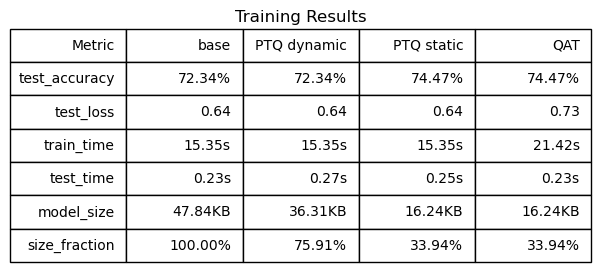

In [133]:
quant_aware_acc, quant_aware_loss, quant_aware_test_time = test(loss_fn, model_int8_qat, test_dataloader, device)
update_results_dict(results, "QAT", quant_aware_acc, quant_aware_loss, train_time, quant_aware_test_time, model_size_bytes(model_int8_qat), model_size_bytes(model_int8_qat)/model_size_bytes(model_fp32))
create_table(results, title="Training Results")

## Conclusion
<!-- <img src="table.png" align="right"/> -->

- PyTorch Quantization good for edge device inference
- $\rightarrow$ Use QAT if you can train, usually best results
- $\rightarrow$ PTQ static if enough data available
- $\rightarrow$ PTQ dynamic basic but easy-to-implement
<!-- when dataset not available and model not too large-->
- Limitations: Model adjustment needed, CPU only (GPU in experimental state)
- $\rightarrow$ Capabilities might be improved in future PyTorch versions
<!--![](table2.png)-->


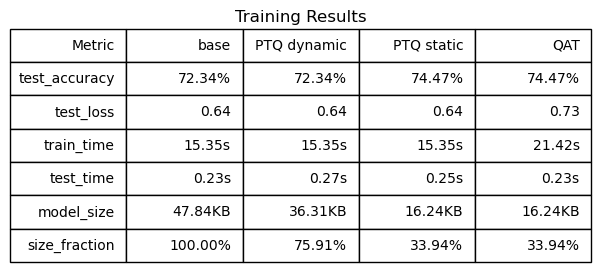

In [134]:
create_table(results, title="Training Results")

## Questions?

## References
- [Quantization PyTorch Documentation](https://pytorch.org/docs/stable/quantization.html)
- [Introdcution to Quantization on PyTorch, blog post](https://pytorch.org/blog/introduction-to-quantization-on-pytorch/)
- [Dynamic Quantization, tutorial](https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html)
- [Static Quantization with Eager Mode in PyTorch, tutorial](https://pytorch.org/tutorials/advanced/static_quantization_tutorial.html)

Quantization formula:
$$Q(x, \text{scale}, \text{zero_point}) = \text{round}\left(\frac{x}{\text{scale}}+\text{zero_point}\right)$$

Supported quantization schemes:
- per-tensor symmetric
- per-tensor asymmetric
- per-channel symmetric
- per-channel asymmetric